# CS3440 - Lab 7

## Objectives
- Continue refining your understand of data mining using Python.
- Apply your skills to a Clustering task

## Suggested Reading
Jake VandePlas, *Python Data Science Handbook*, Chapter 5 (Machine Learning): <https://jakevdp.github.io/PythonDataScienceHandbook/>

This lab script was heavily inspired by / adapted from:
- J. Brownlee (2020), _10 Clustering Algorithms With Python_: <https://machinelearningmastery.com/clustering-algorithms-with-python/>
- J. Huneycut (2018), _An Introduction to Clustering Algorithms in Python_: <https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097>

## Instructions
This is a follow-on tutorial, with some _**TO DO**_ blocks containing specific activities. Please take your time at each block to understand what is being done, and feel free to tinker, explore and modify any block to check your understanding (if you break anything you can always ctrl-Z, or in the worst case download the original Notebook again).
*****

## Clustering

You'll recall from Unit 6 that **clustering** relates to the problem of finding similarity-based groups on (usually unlabelled) data. This is often useful not only to identify scientifically or technically relevant groups in the data for further investigation (e.g., protein function families or groups of people sharing certain characteristics or behaviours) but also sometimes as a pre-processing step to classification (allowing e.g., the fitting of multiple simple models (one for each cluster, in which class separations may be easier) rather than a single massive one).

As with classification and regression, there are multiple types of clustering algorithms (and performance metrics to measure their quality) available. In this tutorial we'll explore a few of those.

To start looking into how we can cluster in Python, let's generate some synthetic data:

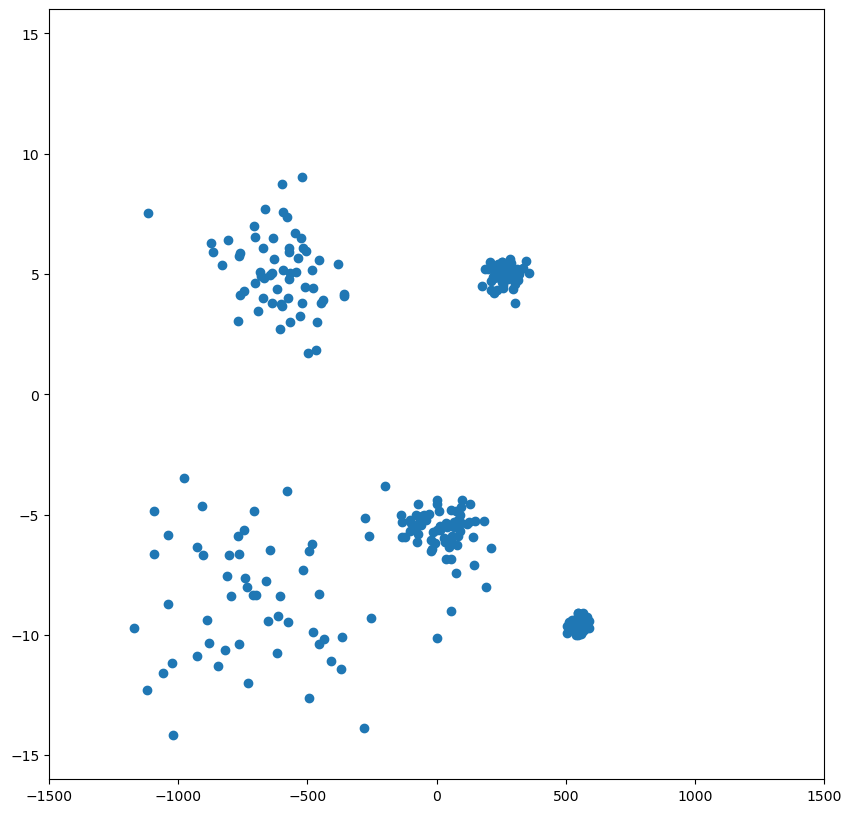

In [127]:
from sklearn.datasets import make_blobs # <- useful function to generate random clustered data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a bunch of clumped data - 5 clusters with different centres and different 'spreads' (regulated by parameter cluster_std)
data = make_blobs(n_samples=300, n_features=2, centers=5, cluster_std=[.2,.4,.8,1.6,3.2], random_state=10)
points = data[0]
points[:,0] = 100 * points[:,0]
groups = data[1]

# visualise data
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(points[:,0], points[:,1])
plt.xlim(-1500,1500)
plt.ylim(-16,16)
plt.show()

The points generated above have some characteristics that will help us investigate certain properties of clustering methods: in particular, they are approximately _globular_ (meaning that they could be easily encircled by an ellipse), they have different _densities_ (which can be a problem for certain methods) and one of the features has a range that's 100 times larger than the other (which can also be a problem).

## K-means

Let's first try clustering this using K-means, with K varying from 2 to 10 (refer to Unit 6 to understand how K-means works):

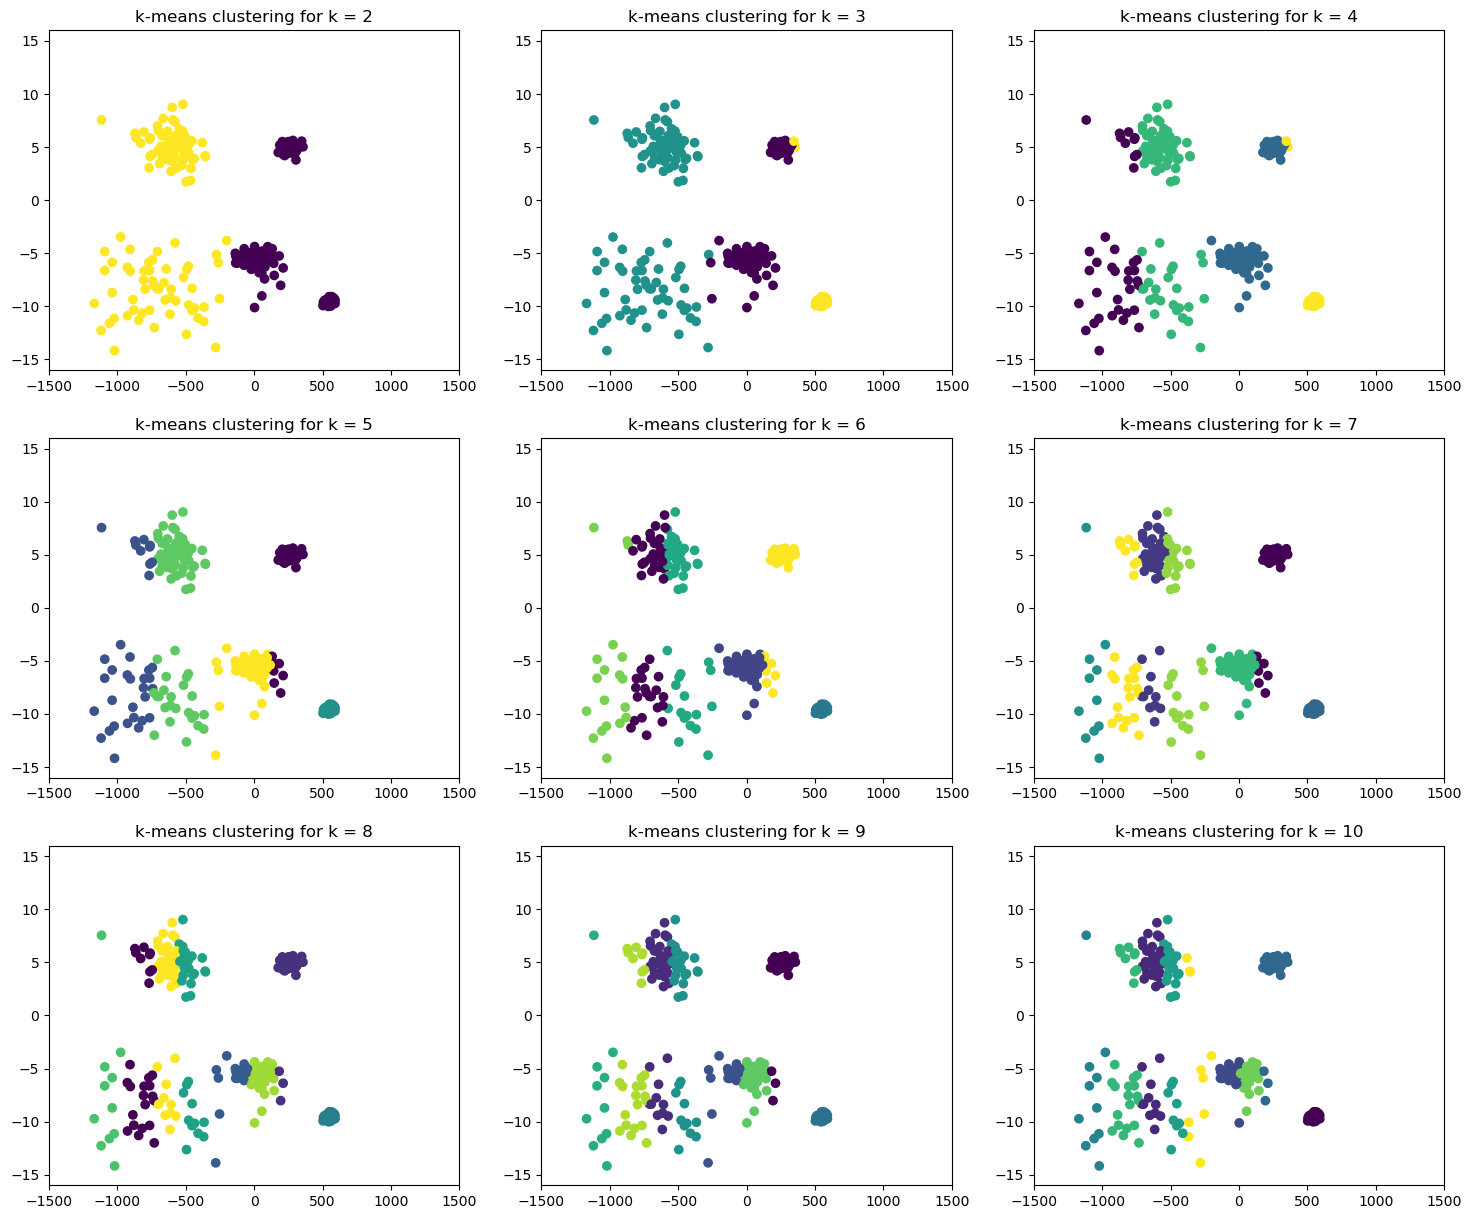

In [128]:
# import KMeans
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = [18, 15]

# create kmeans object
for i in np.arange(2,11):
    # fit kmeans object to data
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(points)
    
    # save new clusters for chart
    y_km = kmeans.fit_predict(points)
    
    plt.subplot(3,3,i-1)
    plt.scatter(points[:,0], points[:,1], c=y_km)
    plt.xlim(-1500,1500)
    plt.ylim(-16,16)
    plt.title("k-means clustering for k = " + str(i))

Notice a problem? Even for the 'correct' value of **K** (5), the resulting grouping looks very strange. **Can you guess why?**


If you look closely, you'll notice that the resulting groups were essentially split along the values of the x-variable (you can almost draw a **K** straight vertical lines and define the clusters). This is because of a problem with distance-based methods that we have mentioned before: their sensitivity to different scales in the variables!

*****
## **TO DO**
(5 minutes)
- Scale both variables in the `points` object to the range [-1, 1] (check, e.g., function `MinMaxScaler` under `sklearn.preprocessing`)
- Re-run the K-means clustering method on the scaled dataset for the same values of **K** used in the example above and plot the resulting clusters (note: don't forget to change the plot limits)
- Check how well your clustering matches the 'original'  grouping of the points (first plot of this notebook) and check how K-means merges (or splits) the clusters when the value of K is not 5.  

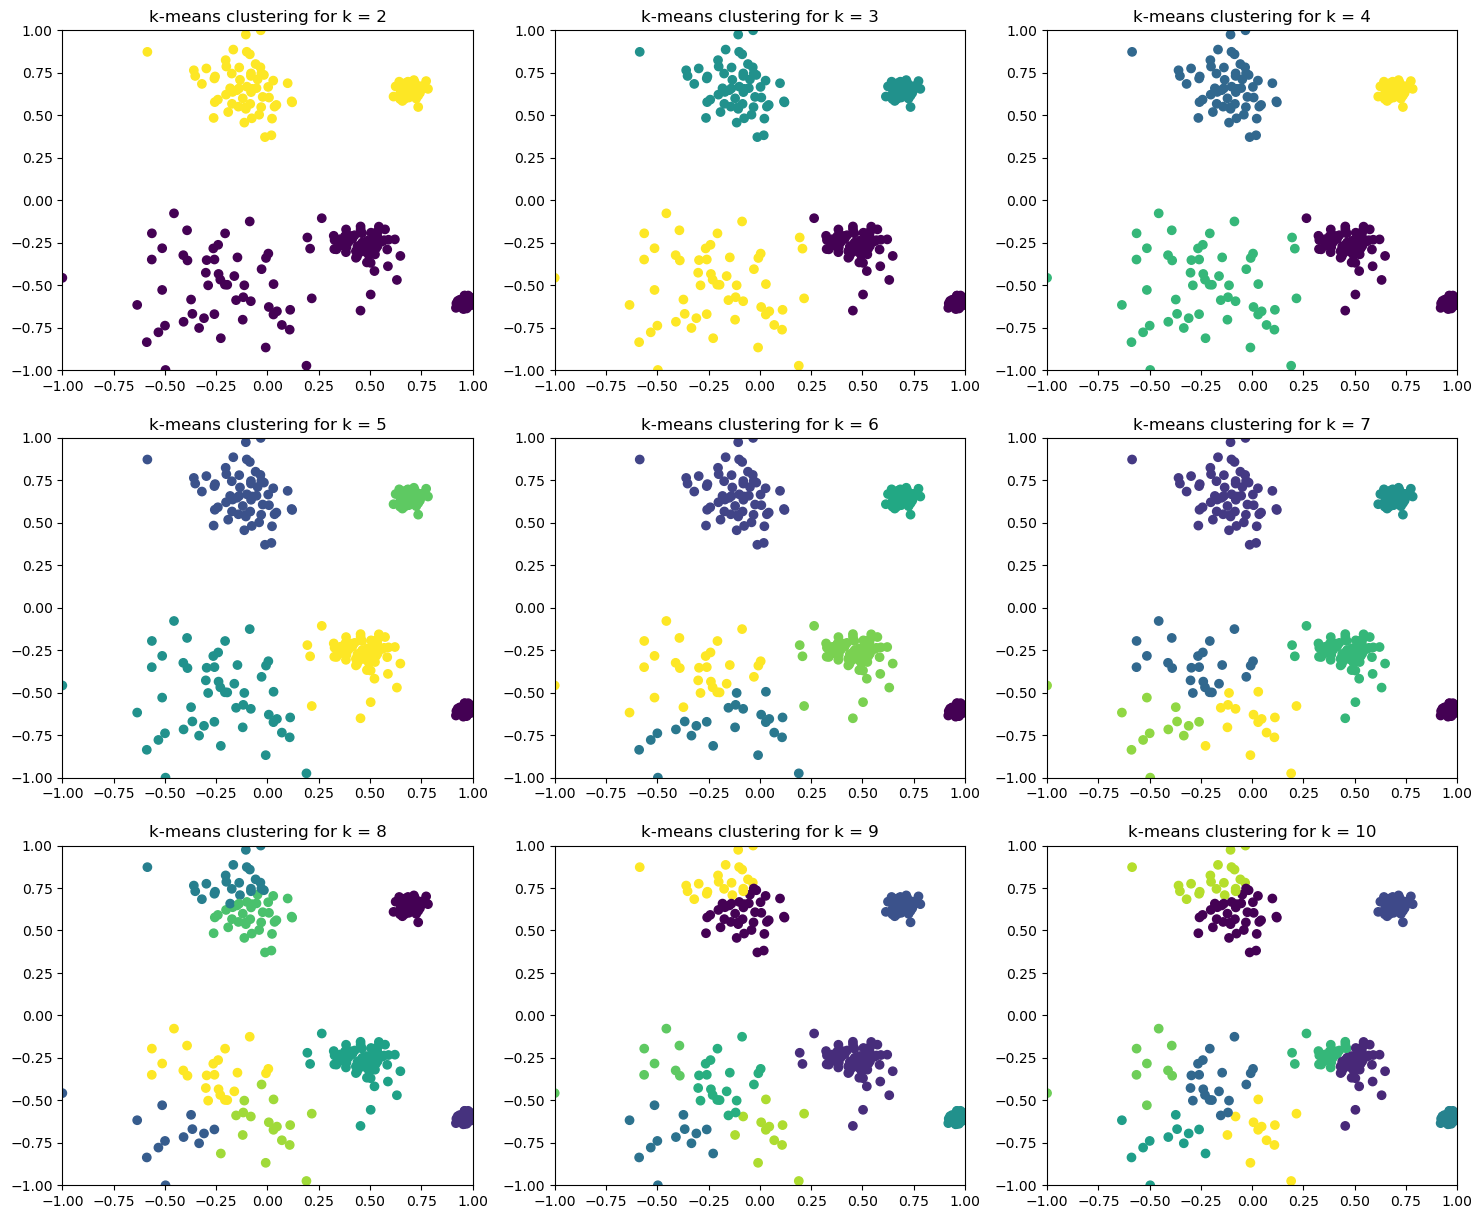

In [129]:
# Write your solution here
#
#
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
scaler.fit(points)
points = scaler.transform(points)
plt.rcParams['figure.figsize'] = [18, 15]

# create kmeans object
for i in np.arange(2,11):
    # fit kmeans object to data
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(points)

    # save new clusters for chart
    y_km = kmeans.fit_predict(points)

    plt.subplot(3,3,i-1)
    plt.scatter(points[:,0], points[:,1], c=y_km)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.title("k-means clustering for k = " + str(i))

## Agglomerative hierarchical clustering

Instead of choosing a number of clusters and starting out with random centroids, Agglomerative Hierarchical Clustering works in a different way: it starts with every point in the data set in its own cluster, and iteratively merges these clusters with the nearest ones (based on a predefined definition of similarity) The process is repeated until al points are grouped together.

Let's see how it works in Python. We'll build a hierarchical clustering using single linkage and the Euclidean distance. Assume we want to cut the tree at the dissimilarity threshold of 0.3:

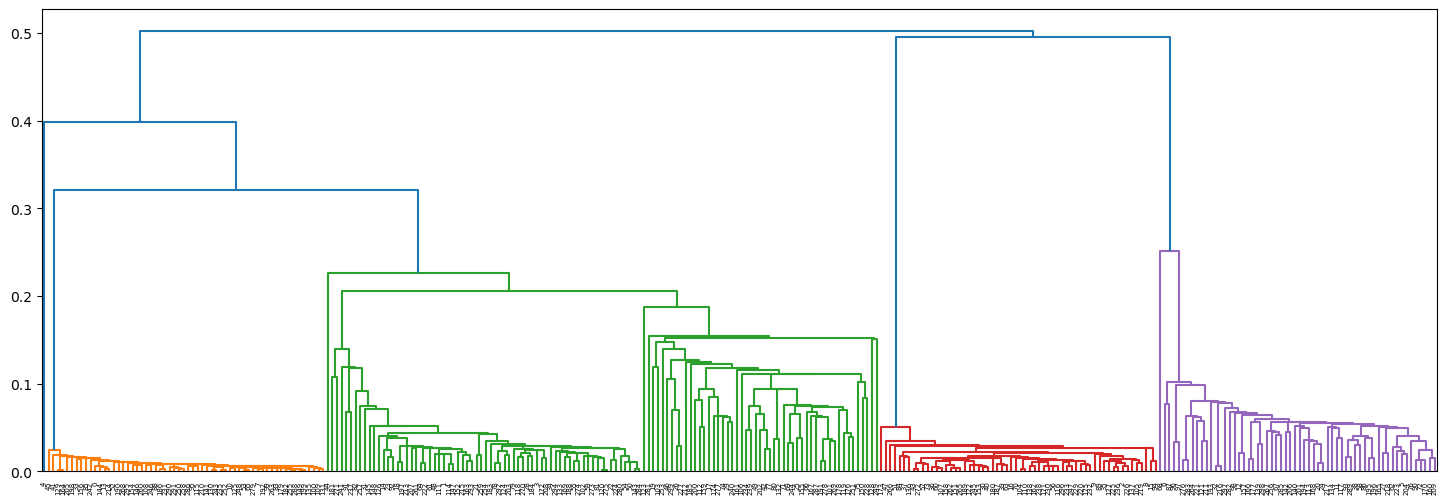

In [130]:
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler

# df is a scaled version of the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
df = pd.DataFrame(scaler.fit_transform(points))

# linkage matrix
linkage_matrix = sch.linkage(df, method='single', metric='euclidean')

# dendrogram
# color_threshold will defines the colouring - try changing it!
plt.rcParams['figure.figsize'] = [18, 6]
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=.3)

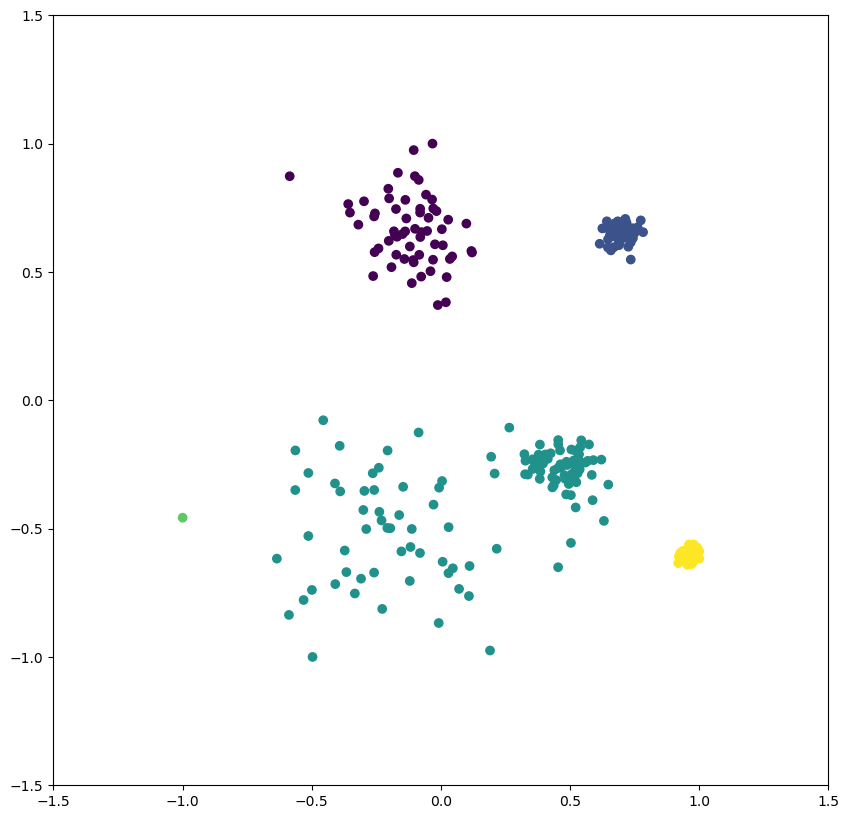

In [131]:
# We can also get the clustering in a different way 
from sklearn.cluster import AgglomerativeClustering

# n_clusters defines the number of clusters to return 
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'single')
y_hc = hc.fit_predict(df)

# visualise:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=y_hc, cmap='viridis')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

Notice again that the clustering algorithm didn't really capture the underlying data-generating structure - the difference in density made single linkage not particularly appropriate here. If we use a different linkage function we'll see other patterns emerge (you can check Ward's linkage approach [here](https://www.statistics.com/glossary/wards-linkage/)):

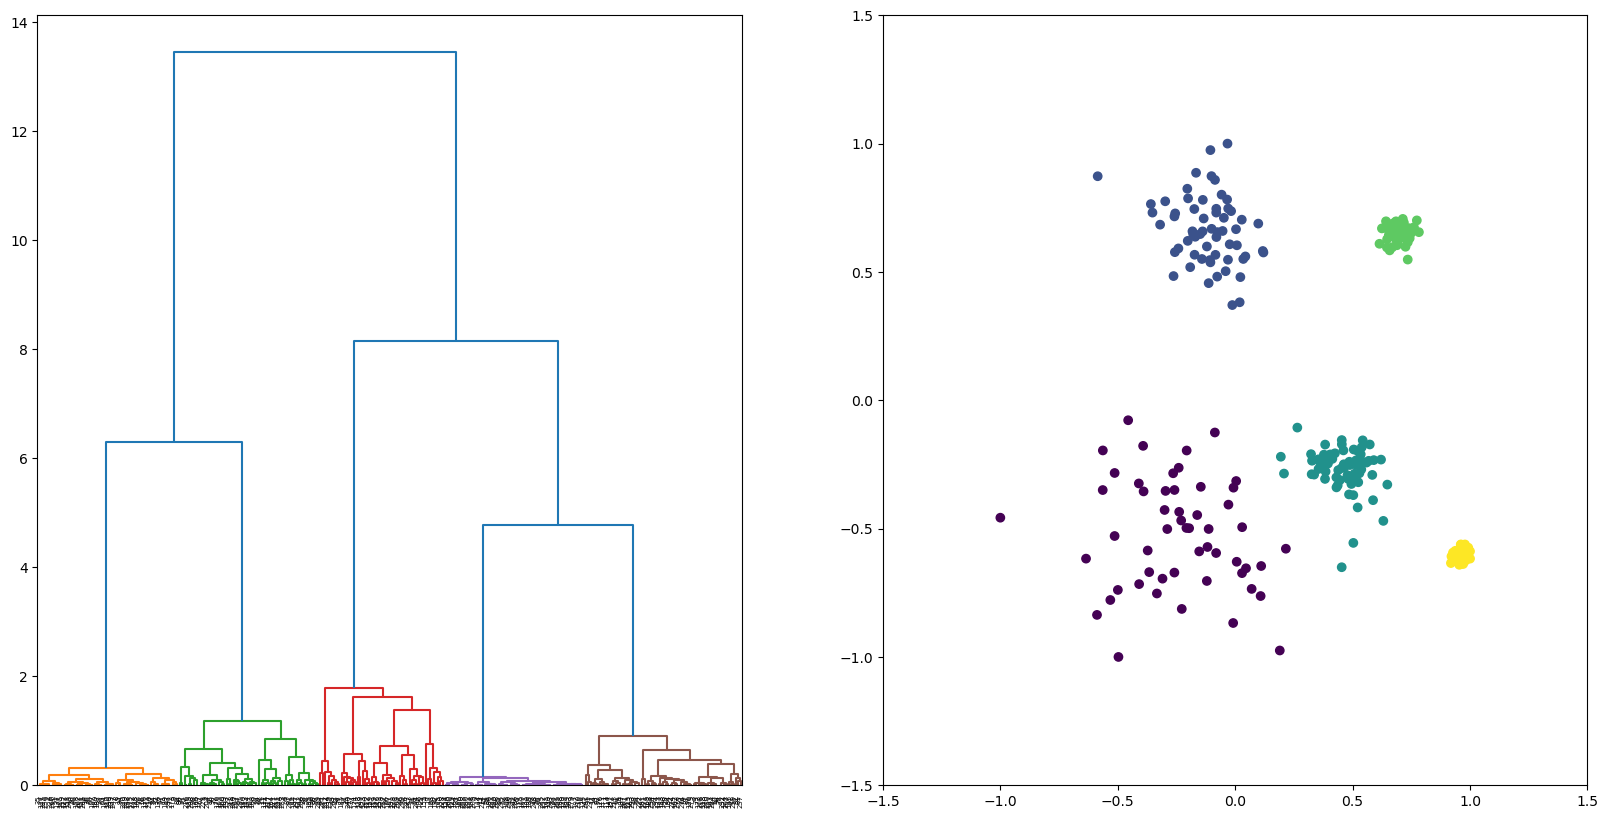

In [132]:
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward') 
y_hc = hc.fit_predict(df)

# visualise dendrogram
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,2,1)
dendrogram = sch.dendrogram(sch.linkage(df, method='ward', metric='euclidean'), color_threshold=3)

plt.subplot(1,2,2)
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=y_hc, cmap='viridis')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

## DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) involves finding high-density areas in the domain and expanding those areas of the feature space around them as clusters.

DBSCAN groups 'densely grouped' data points. It can identify clusters in large spatial datasets by looking at the local density, and automatically discounting outliers. It also does not require a predefined number of clusters. This method requires only two parameters: _epsilon_ (the radius of a ball created around each data point to check the density) and _minPoints_ (the minimum number of data points inside the epsilon-neighbourhood of a point for it to be considered a **Core** point. For more details on DBSCAN please check [this article](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/) and the lecture slides for Unit 6.

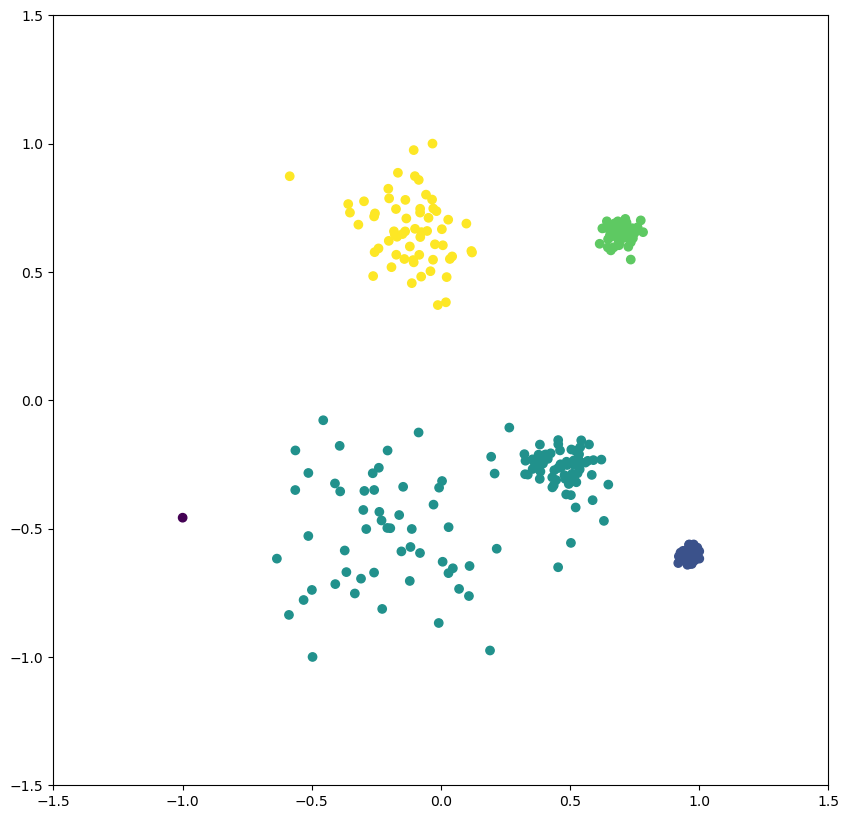

In [133]:
# dbscan clustering
from sklearn.cluster import DBSCAN

# define the model
model = DBSCAN(eps=0.3, min_samples=10)

# fit model and predict clusters
y_db = model.fit_predict(df)

# retrieve unique clusters
clusters = np.unique(y_db)

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=y_db, cmap='viridis')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()


## **TO DO**
(5 minutes)

Try changing the eps and minpoints parameters of DBSCAN and observe the effect on the resulting clusters.

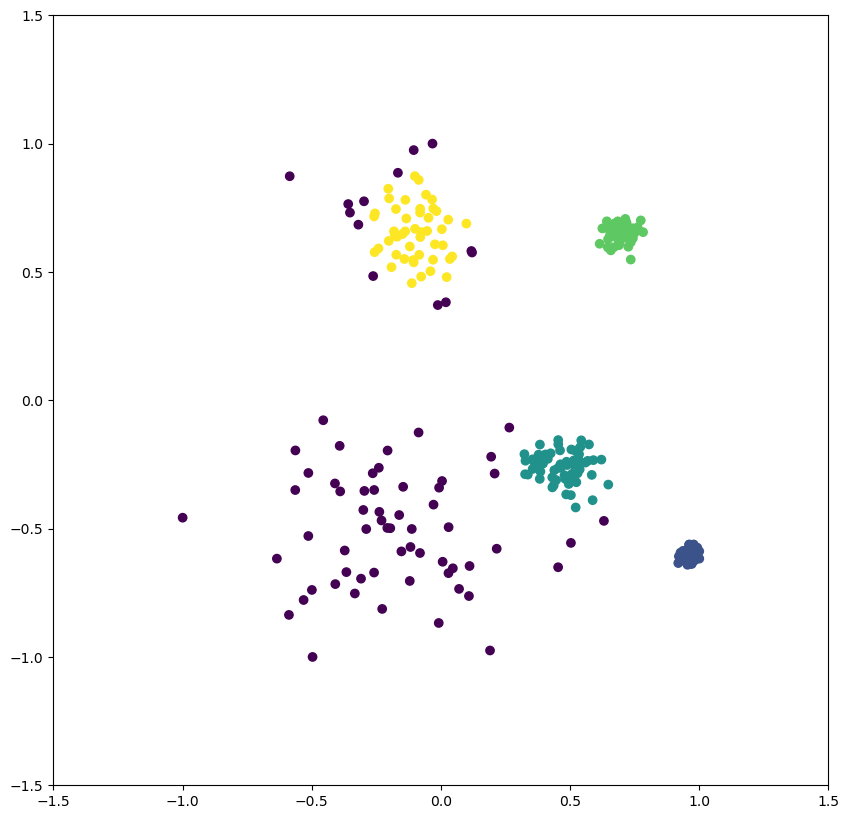

In [134]:
# Write your solution here
#
#
# define the model
model = DBSCAN(eps=0.1, min_samples=10)

# fit model and predict clusters
y_db = model.fit_predict(df)

# retrieve unique clusters
clusters = np.unique(y_db)

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=y_db, cmap='viridis')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()


*****
DBSCAN has some very interesting characteristics, but one major weakness: since it is a density-based methods, it does not deal well with clusters of varying densities (as is the case in the example above). One of its main advantages, however, is its ability to identify clusters of arbitrary shapes. Consider the example data below:

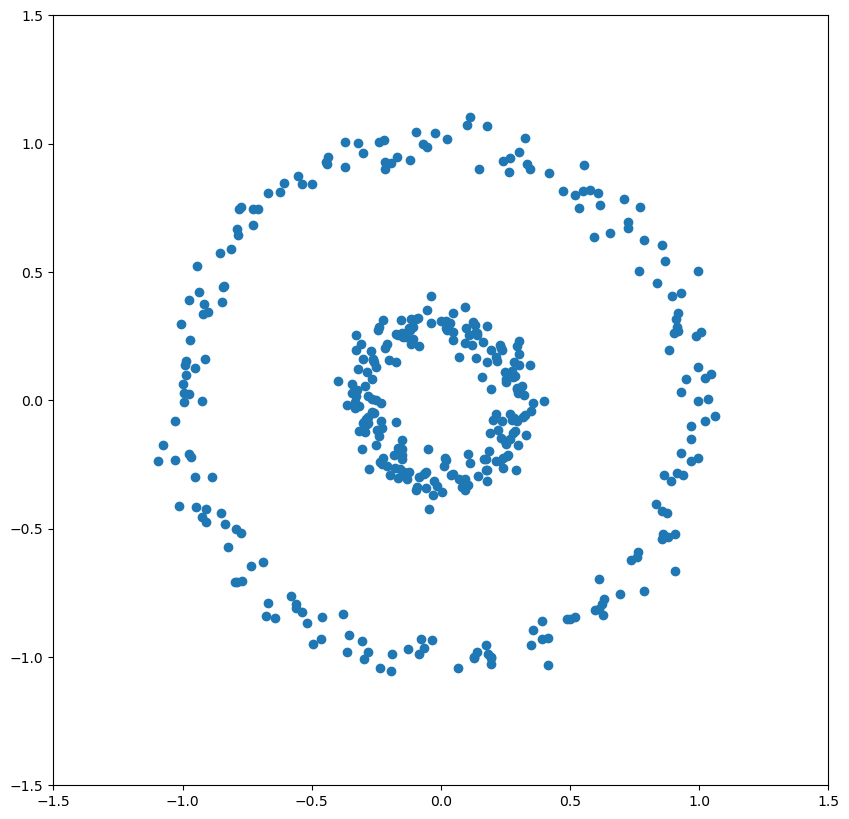

In [135]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=400, factor=0.3, noise=0.05, random_state=0)

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X2[:,0], X2[:,1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

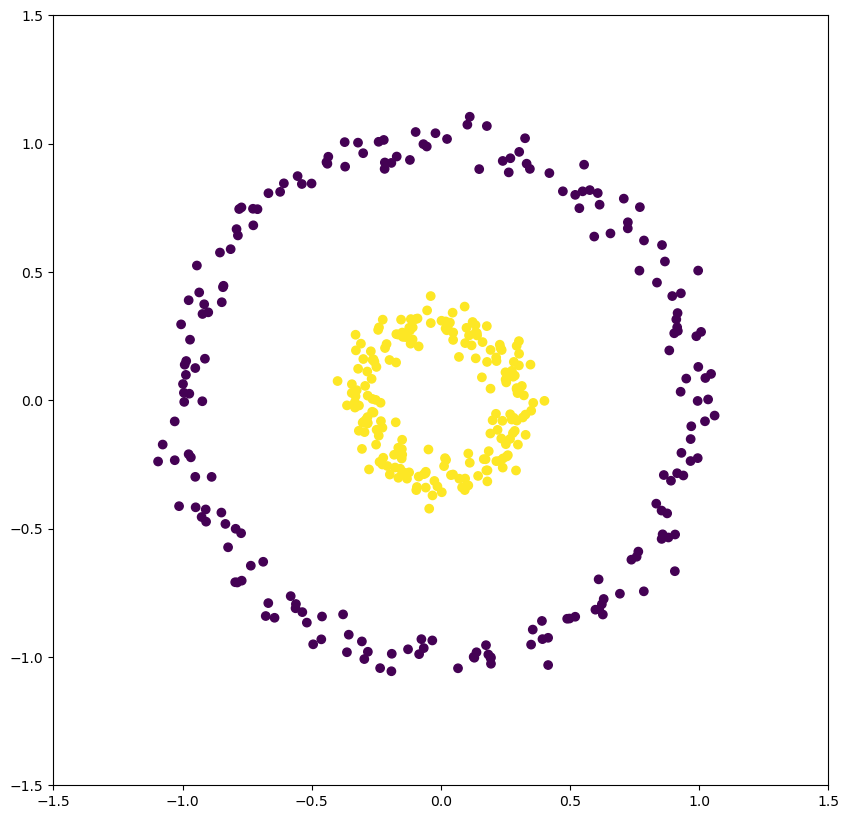

In [136]:
y_db2 = model.fit_predict(X2)

# retrieve unique clusters

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X2[:,0], X2[:,1], c=y_db2)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

*****
## **TO DO**
(30 minutes)

As a final exercise in clustering, we'll try to cluster a more challenging dataset: the _hepC_ dataset, which contains features calculated on proteins of the Hepatitis C virus. The dataset is available as file _hepC.csv_ on Blackboard. It has the following structure:

- Column 0: Protein ID (must be removed prior to clustering)
- Columns 1-785: Features calculated based on the protein sequences.

You activities are as follows. For each dataset:

### Part 1
- Check that all feature columns (columns 1-785) are numerical
- Verify if any features contain missing values. If so:
    - If there are only a few missing values (1% or less) use a simple imputation method to attribute placeholder values (we saw examples of imputation in earlier labs)
    - If there are more than 1% of values missing for a given feature, remove that feature from the dataset
- Scale all numerical features to the range (0, 1)
- Cluster the points using DBSCAN

### Part 2
A good way to visualise the clustering structure in high-dimensional data is t-SNE (read more about t-SNE [here](https://distill.pub/2016/misread-tsne/)). Once you've developed your clustering, adapt the Code Block below to visualise your groups. You may want to change your clustering parameters a few times and visualise the effect on the clustering.

### Part 3
Change the clustering method to Agglomerative Hierarchical clustering and visualise the resulting dendrogram.

*****

**One final note**: not all datasets will have a "nice" clustering structure - sometimes the data simply does not separate well in the feature space used. ;)

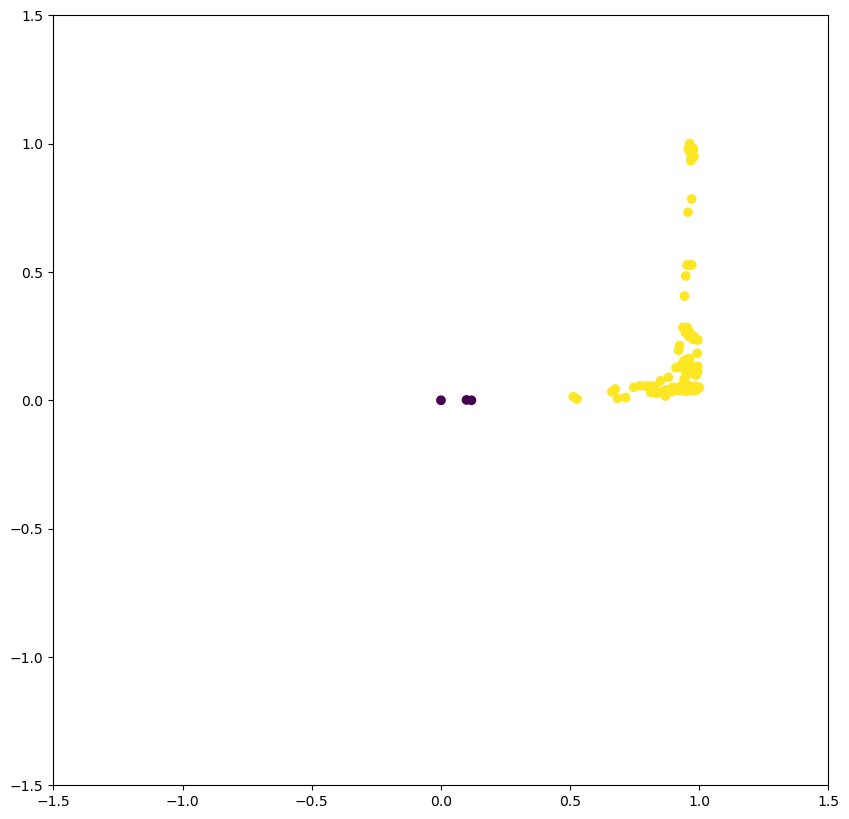

In [146]:
# For the hepC dataset

import pandas as pd

# Part 1 goes here

X = pd.read_csv("hepC(1).csv")
X = X.select_dtypes(include=np.number)

scaler = MinMaxScaler(feature_range=[0,1])
X = scaler.fit_transform(X)

model = DBSCAN(eps=0.3, min_samples=10, metric='cosine')
y_db = model.fit_predict(X)
clusters = np.unique(y_db)
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X[:,0], X[:,1], c=y_db, cmap='viridis')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()
#
# continue here
#



/Users/hanzalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


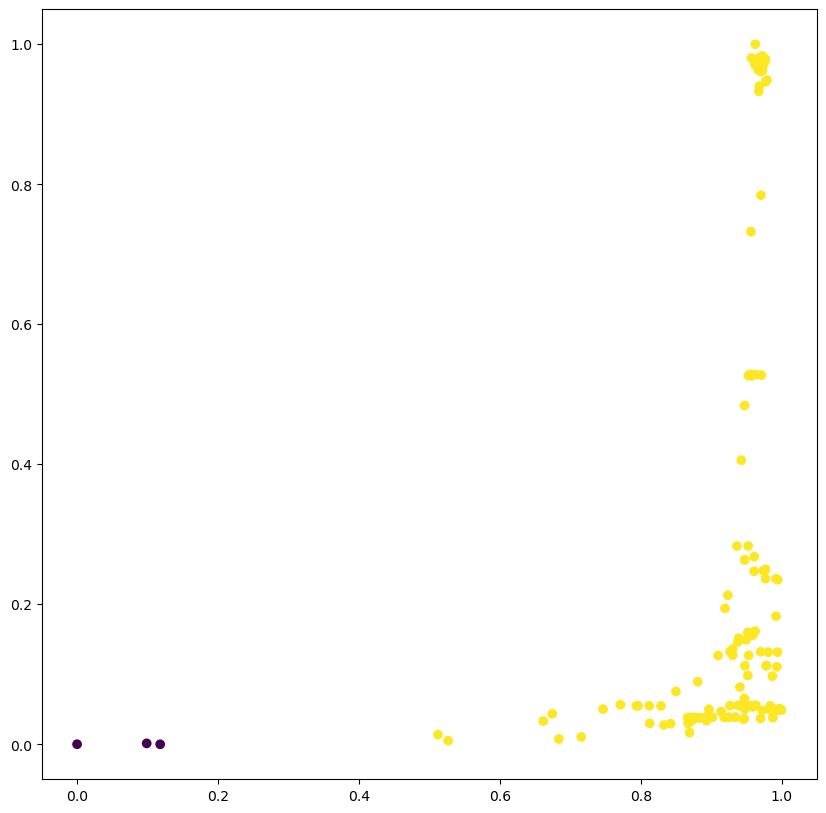

In [147]:
# Uncomment and adapt rows as needed (for part 2) 

import numpy as np
from sklearn.manifold import TSNE

# Remove ID column (if you haven't done so before)
## ALREADY REMOVED

# Run tSNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Plot the 2D projection of the data.
# NOTE: this assumes you fit your clustering model and found the clusters using y = model.predict(X)

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X[:,0], X[:,1], c=y_db)
plt.show()

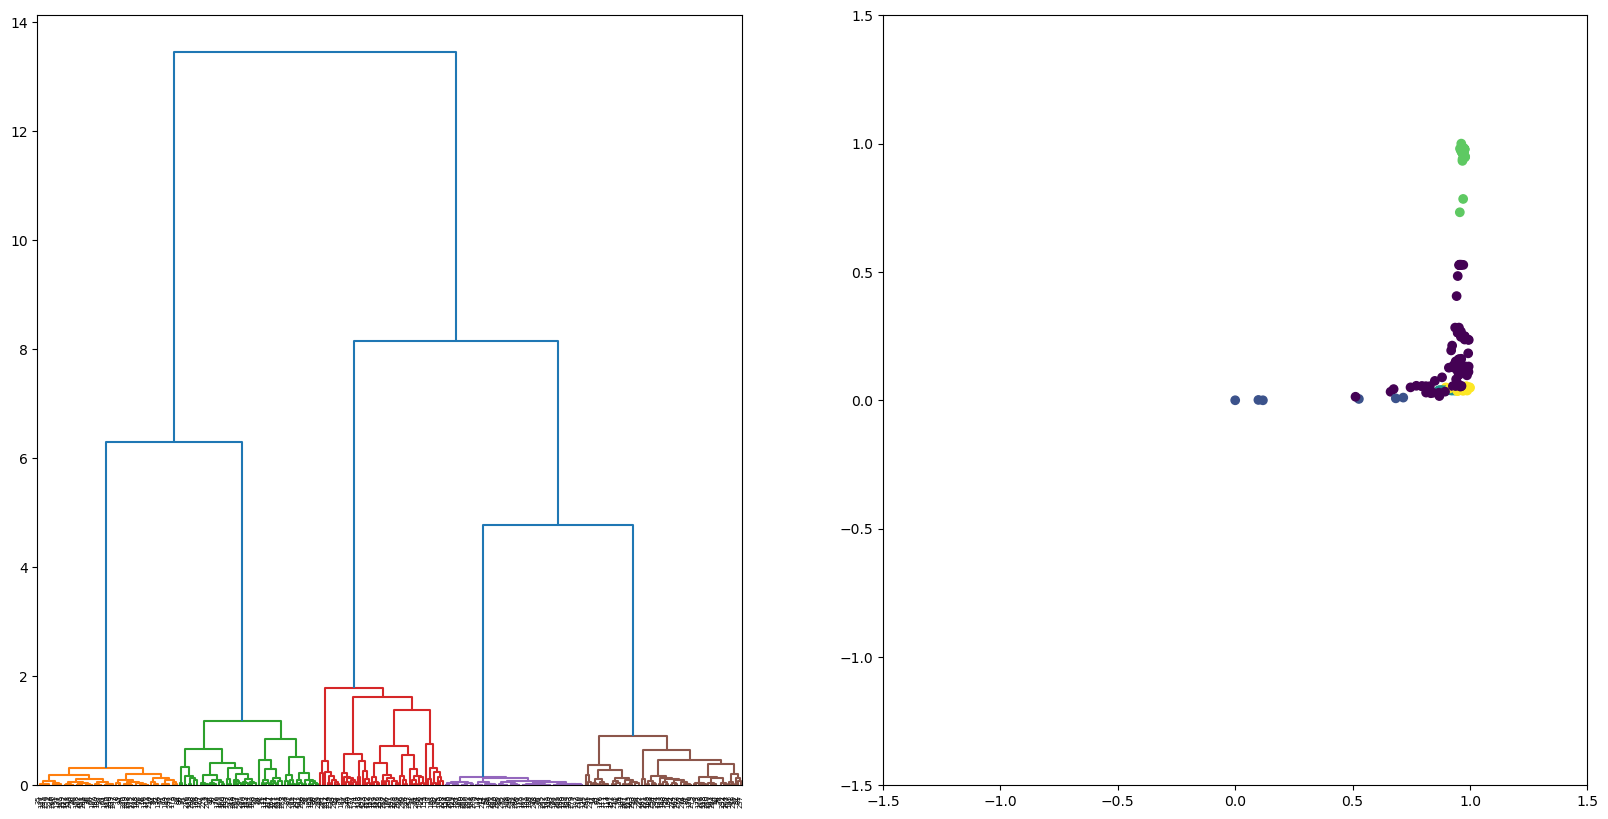

In [149]:
# Part 3 goes here
#
#
#
hc = AgglomerativeClustering(n_clusters=5, affinity= 'euclidean', linkage='ward')
y_hc = hc.fit_predict(X)

# visualise dendrogram
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,2,1)
dendrogram = sch.dendrogram(sch.linkage(df, method='ward', metric='euclidean'), color_threshold=3)

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=y_hc, cmap='viridis')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()